# PHÂN TÍCH CHẤT LƯỢNG RƯỢU ĐỎ

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

## Bảng phân công công việc

## Phát biểu bài toán

## Giới thiệu về dữ liệu

## Import thư viện

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)
library(MLmetrics)
library(pls)
# library(caret)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

In [2]:
# Hàm tiền xử lý dữ liệu với box-cox
bc_transform <- function(df) {
    col.names <- names(df)

    transformed_df <- df
    
    for (name in names(df))
    {
        col.name <- name

        print(col.name)

        # Rút trích biến phản hồi
        response_variable <- df[[col.name]]
        
        if (!is.numeric(response_variable)) {
            print(col.name)
            stop("The column to be transformed must be numeric.")
        }
        
        if (any(response_variable <= 0)) {
            # Shift the values to be positive
            shift_value <- abs(min(response_variable)) + 1
            response_variable <- response_variable + shift_value
        }
        
        # Áp dụng box-cox transform để tìm lambda tối ưu
        boxcox_result <- boxcox(lm(response_variable ~ 1), plotit = FALSE)
        optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
        print(paste("Optimal lambda:", optimal_lambda))
        
        # Sử dụng lambda tối ưu để biến đổi dữ liệu
        if (optimal_lambda == 0) {
            transformed_response <- log(response_variable)
        } else {
            transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
        }
        
        # Gán biến đã được biến đổi
        transformed_df[[col.name]] <- transformed_response
    }
    
    return(transformed_df)
}

indicator <- function(model, y_pred, y_true) {
     adj.r.sq <- summary(model)$adj.r.squared
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("Adjusted R-squared: ", round(adj.r.sq, 4)))
     print(paste0("MSE: ", round(mse, 4)))
     print(paste0("RMSE: ", round(rmse, 4)))
     print(paste0("MAE: ", round(mae, 4)))
}


metrics <- function(y_pred, y_true){
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("MSE: ", round(mse, 6)))
     print(paste0("RMSE: ", round(rmse, 6)))
     print(paste0("MAE: ", round(mae, 6)))
     corPredAct <- cor(y_pred, y_true)
     print(paste0("Correlation: ", round(corPredAct, 6)))
     print(paste0("R^2 between y_pred & y_true: ", round(corPredAct^2, 6)))
}

CheckNormal <- function(model) {
     hist(model$residuals, breaks = 30)
     shaptest <- shapiro.test(model$residuals)
     print(shaptest)
     if (shaptest$p.value <= 0.05) {
          print("H0 rejected: the residuals are NOT distributed normally")
     } else {
          print("H0 failed to reject: the residuals ARE distributed normally")
     }
}

CheckHomos <- function(model){
     plot(model$fitted.values, model$residuals)
     abline(h = 0, col = "red")
     BP <- bptest(model)
     print(BP)
     if (BP$p.value <= 0.05) {
          print("H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)")
     } else {
          print("H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)")
     }
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read.table("../../data/part2/wine+quality/winequality-red.csv", header=TRUE, sep=";", stringsAsFactors = FALSE)
str(raw_data)

'data.frame':	1599 obs. of  12 variables:
 $ fixed.acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile.acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free.sulfur.dioxide : num  11 25 15 17 11 13 15 15 9 17 ...
 $ total.sulfur.dioxide: num  34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...


In [4]:
# # Specify the path to your .names file
# file_path <- "../../data/part2/wine+quality/winequality.names"

# # Read the .names file
# names_content <- readLines(file_path)

# # Extract the title
# title <- names_content[grepl("Title:", names_content)]
# # print(title)

# # Extract the sources
# sources <- names_content[grepl("Sources", names_content):(which(names_content == "")[1] - 1)]
# # print(sources)

# # Extract the attribute information
# attribute_info_start <- which(grepl("Attribute information:", names_content))
# attribute_info <- names_content[(attribute_info_start + 1):(attribute_info_start + 11)]
# # print(attribute_info)

# # Extract the number of instances
# num_instances <- names_content[grepl("Number of Instances:", names_content)]
# print(num_instances)

# # Extract the number of attributes
# num_attributes <- names_content[grepl("Number of Attributes:", names_content)]
# print(num_attributes)

# # Extract the missing attribute values
# missing_values <- names_content[grepl("Missing Attribute Values:", names_content)]
# print(missing_values)

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [5]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 4898 dòng và 12 cột
dim(raw_data)

[1] 1599   12

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [6]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- (raw_data[duplicated(raw_data), ])
length(duplicates)

[1] 12

In [7]:
clean_data <- unique(raw_data)

In [8]:
duplicates <- clean_data[duplicated(clean_data), ]
if (nrow(duplicates) == 0) {
  print("No duplicates found. Data is clean.")
} else {
  print("Duplicates still exist:")
  print(duplicates)
}

dim(raw_data)
dim(clean_data)

[1] "No duplicates found. Data is clean."


[1] 1599   12

[1] 1359   12

### Mỗi cột mang ý nghĩa gì?

In [9]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

'data.frame':	1599 obs. of  12 variables:
 $ fixed.acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile.acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free.sulfur.dioxide : num  11 25 15 17 11 13 15 15 9 17 ...
 $ total.sulfur.dioxide: num  34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...


### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [10]:
wine_quality_red <- raw_data

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [11]:
# Hàm tính toán tỷ lệ missing value
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Hàm tính toán trung vị (median)
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 25% (Q1)
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 75% (Q3)
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [12]:
# Lựa chọn những cột kiểu số
num_col_info_df <- as.data.frame(wine_quality_red) %>% select_if(is.numeric)

# Tổng hợp các kết quả thống kê
num_col_info_df <- as.data.frame(wine_quality_red) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

# In kết quả ra
print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 36 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 12 × 7
   variable             missing   min lower median upper     max
   <chr>                  <dbl> <dbl> <dbl>  <dbl> <dbl>   <dbl>
 1 fixed.acidity              0 4.6     7.1    7.9   9.2  15.9  
 2 volatile.acidity           0 0.12    0.4    0.5   0.6   1.58 
 3 citric.acid                0 0       0.1    0.3   0.4   1    
 4 residual.sugar             0 0.9     1.9    2.2   2.6  15.5  
 5 chlorides                  0 0.012   0.1    0.1   0.1   0.611
 6 free.sulfur.dioxide        0 1       7     14    21    72    
 7 total.sulfur.dioxide       0 6      22     38    62   289    
 8 density                    0 0.990   1      1     1     1.00 
 9 pH                         0 2.74    3.2    3.3   3.4   4.01 
10 sulphates                  0 0.33    0.6    0.6   0.7   2    
11 alcohol                    0 8.4     9.5   10.2  11.1  14.9  
12 quality                    0 3       5      6     6     8    


In [13]:
print(summary(as.data.frame(wine_quality_red) %>% select_if(is.numeric)))

 fixed.acidity   volatile.acidity  citric.acid    residual.sugar  
 Min.   : 4.60   Min.   :0.1200   Min.   :0.000   Min.   : 0.900  
 1st Qu.: 7.10   1st Qu.:0.3900   1st Qu.:0.090   1st Qu.: 1.900  
 Median : 7.90   Median :0.5200   Median :0.260   Median : 2.200  
 Mean   : 8.32   Mean   :0.5278   Mean   :0.271   Mean   : 2.539  
 3rd Qu.: 9.20   3rd Qu.:0.6400   3rd Qu.:0.420   3rd Qu.: 2.600  
 Max.   :15.90   Max.   :1.5800   Max.   :1.000   Max.   :15.500  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.01200   Min.   : 1.00       Min.   :  6.00       Min.   :0.9901  
 1st Qu.:0.07000   1st Qu.: 7.00       1st Qu.: 22.00       1st Qu.:0.9956  
 Median :0.07900   Median :14.00       Median : 38.00       Median :0.9968  
 Mean   :0.08747   Mean   :15.87       Mean   : 46.47       Mean   :0.9967  
 3rd Qu.:0.09000   3rd Qu.:21.00       3rd Qu.: 62.00       3rd Qu.:0.9978  
 Max.   :0.61100   Max.   :72.00       Max.   :289.00       Max.   :1

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

## Xử lý đa cộng tuyến

In [14]:
cor_matrix <- round(cor(wine_quality_red), 2)
cor_matrix

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
fixed.acidity,1.00,-0.26,0.67,0.11,0.09,-0.15,-0.11,0.67,-0.68,0.18,-0.06,0.12
volatile.acidity,-0.26,1.00,-0.55,0.00,0.06,-0.01,0.08,0.02,0.23,-0.26,-0.20,-0.39
citric.acid,0.67,-0.55,1.00,0.14,0.20,-0.06,0.04,0.36,-0.54,0.31,0.11,0.23
residual.sugar,0.11,0.00,0.14,1.00,0.06,0.19,0.20,0.36,-0.09,0.01,0.04,0.01
chlorides,0.09,0.06,0.20,0.06,1.00,0.01,0.05,0.20,-0.27,0.37,-0.22,-0.13
free.sulfur.dioxide,-0.15,-0.01,-0.06,0.19,0.01,1.00,0.67,-0.02,0.07,0.05,-0.07,-0.05
total.sulfur.dioxide,-0.11,0.08,0.04,0.20,0.05,0.67,1.00,0.07,-0.07,0.04,-0.21,-0.19
density,0.67,0.02,0.36,0.36,0.20,-0.02,0.07,1.00,-0.34,0.15,-0.50,-0.17
pH,-0.68,0.23,-0.54,-0.09,-0.27,0.07,-0.07,-0.34,1.00,-0.20,0.21,-0.06
sulphates,0.18,-0.26,0.31,0.01,0.37,0.05,0.04,0.15,-0.20,1.00,0.09,0.25


In [15]:
threshold <- 0.7
high_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(abs(cor_matrix[i, j]) > threshold) {
      high_cor_pairs <- rbind(high_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(high_cor_pairs)

list()


In [16]:
threshold <- -0.7

neg_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(cor_matrix[i, j] < threshold) {
      neg_cor_pairs <- rbind(neg_cor_pairs, 
                             data.frame(Var1 = rownames(cor_matrix)[i], 
                                        Var2 = colnames(cor_matrix)[j], 
                                        value = cor_matrix[i, j]))
    }
  }
}

print(neg_cor_pairs)

list()


In [17]:
model <- lm(quality ~ ., data = wine_quality_red)
vif_values <- vif(model)
print(vif_values)

       fixed.acidity     volatile.acidity          citric.acid 
            7.767512             1.789390             3.128022 
      residual.sugar            chlorides  free.sulfur.dioxide 
            1.702588             1.481932             1.963019 
total.sulfur.dioxide              density                   pH 
            2.186813             6.343760             3.329732 
           sulphates              alcohol 
            1.429434             3.031160 


In [18]:
threshold <- 3
while (any(vif_values > threshold)) {
  highest_vif <- which.max(vif_values)
  variable_to_remove <- names(vif_values)[highest_vif]
  formula <- as.formula(paste("quality ~ . -", variable_to_remove))
  model <- update(model, formula)
  vif_values <- vif(model)
}

In [19]:
print(vif_values)
summary(model)

    volatile.acidity          citric.acid       residual.sugar 
            1.784963             2.780557             1.386375 
           chlorides  free.sulfur.dioxide total.sulfur.dioxide 
            1.401232             1.939209             2.069396 
             density                   pH            sulphates 
            2.430096             1.610775             1.396382 
             alcohol 
            2.136067 



Call:
lm(formula = quality ~ volatile.acidity + citric.acid + residual.sugar + 
    chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol, data = wine_quality_red)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.65461 -0.36856 -0.04552  0.45670  2.03464 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           6.1795700 13.4367180   0.460   0.6456    
volatile.acidity     -1.0777894  0.1209486  -8.911  < 2e-16 ***
citric.acid          -0.1353226  0.1387582  -0.975   0.3296    
residual.sugar        0.0101047  0.0135372   0.746   0.4555    
chlorides            -1.9684566  0.4076978  -4.828 1.51e-06 ***
free.sulfur.dioxide   0.0045916  0.0021580   2.128   0.0335 *  
total.sulfur.dioxide -0.0034272  0.0007089  -4.835 1.46e-06 ***
density              -1.5167406 13.3889717  -0.113   0.9098    
pH                   -0.5462340  0.1332577  -4.099 4.36e-05 ***
sulphates             0.8995900  

In [20]:
clean_df <- wine_quality_red[,names((vif_values))]
clean_df$quality <- wine_quality_red$quality
head(clean_df)

,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
6,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


In [21]:
wine_quality_red <- clean_df

## Khảo sát ngoại lai

In [22]:
# Khảo sát ngoại lai theo biến diff
diff_data <- wine_quality_red
outliers_index <- list()
extreme_outliers_index <- list()

for (i in 1:ncol(diff_data)) {
  # Tính toán Q1, Q3 và IQR
  Q1 = quantile(diff_data[, i], 0.25, na.rm = TRUE)
  Q3 = quantile(diff_data[, i], 0.75, na.rm = TRUE)
  IQR = Q3 - Q1

  # Xác định ngoại lai
  outliers_index_i = diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR)
  # outliers_i = diff_data[diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR), i]

  # Lưu trữ ngoại lai
  field_name = names(diff_data)[i]
  outliers_index[[field_name]] = which(outliers_index_i)

  # Xác định cực ngoại lai
  extreme_outliers_index_i = diff_data[, i] < (Q1 - 3 * IQR) | diff_data[, i] > (Q3 + 3 * IQR)
  extreme_outliers_index[[field_name]] = which(extreme_outliers_index_i)
}
# In kết quả theo từng biến ra màn hình
for (i in 1:ncol(diff_data)) {
  print(paste("Biến:", names(diff_data)[i]))
  print(paste("Số ngoại lai:", length(outliers_index[[names(diff_data)[i]]])))
  print(paste("Số cực ngoại lai:", length(extreme_outliers_index[[names(diff_data)[i]]])))
}

# Tìm tổng số quan trắc ngoại lai và cực ngoại lai thực sự
outliers = c()
extreme_outliners = c()
for (i in 1:ncol(diff_data)){
    outliers = c(outliers, outliers_index[[names(diff_data)[i]]])
    extreme_outliners = c(extreme_outliners, extreme_outliers_index[[names(diff_data)[i]]])
}

outliers = unique(outliers)
extreme_outliners = unique(extreme_outliners)
print(paste("Tổng số ngoại lai:", length(outliers)))
print(paste("Tổng số cực ngoại lai:", length(extreme_outliners)))

[1] "Biến: volatile.acidity"
[1] "Số ngoại lai: 19"
[1] "Số cực ngoại lai: 1"
[1] "Biến: citric.acid"
[1] "Số ngoại lai: 1"
[1] "Số cực ngoại lai: 0"
[1] "Biến: residual.sugar"
[1] "Số ngoại lai: 155"
[1] "Số cực ngoại lai: 88"
[1] "Biến: chlorides"
[1] "Số ngoại lai: 112"
[1] "Số cực ngoại lai: 67"
[1] "Biến: free.sulfur.dioxide"
[1] "Số ngoại lai: 30"
[1] "Số cực ngoại lai: 4"
[1] "Biến: total.sulfur.dioxide"
[1] "Số ngoại lai: 55"
[1] "Số cực ngoại lai: 2"
[1] "Biến: density"
[1] "Số ngoại lai: 45"
[1] "Số cực ngoại lai: 0"
[1] "Biến: pH"
[1] "Số ngoại lai: 35"
[1] "Số cực ngoại lai: 2"
[1] "Biến: sulphates"
[1] "Số ngoại lai: 59"
[1] "Số cực ngoại lai: 16"
[1] "Biến: alcohol"
[1] "Số ngoại lai: 13"
[1] "Số cực ngoại lai: 0"
[1] "Biến: quality"
[1] "Số ngoại lai: 28"
[1] "Số cực ngoại lai: 0"
[1] "Tổng số ngoại lai: 393"
[1] "Tổng số cực ngoại lai: 160"


In [23]:
# cleaned_df <- wine_quality_red[-extreme_outliners, ]

cleaned_df <- wine_quality_red[-outliers, ]
dim(cleaned_df)
dim(wine_quality_red)

[1] 1206   11

[1] 1599   11

In [24]:
wine_quality_red <- cleaned_df

## Quay lại bước phân tích xen kẽ với tiền xử lý dữ liệu

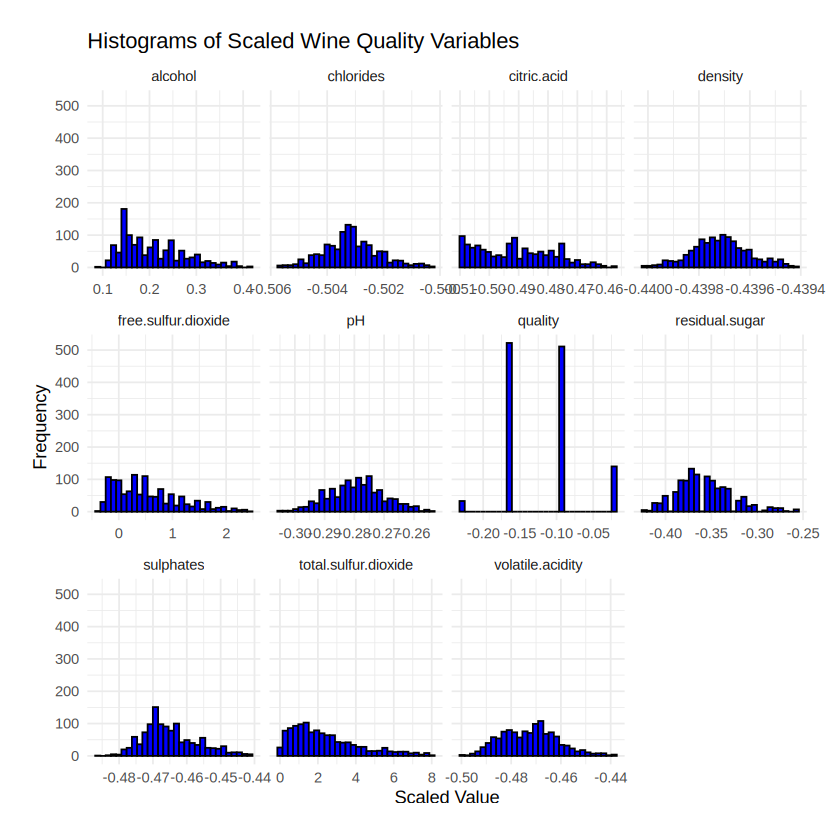

In [25]:
# Converting data to long format and scaling the values
wine_quality_red_long <- wine_quality_red %>%
  pivot_longer(cols = names(wine_quality_red), names_to = "variable", values_to = "value") %>%
  mutate(value = scale(value))  # Scale the data

# 1. Histograms of Scaled Data
ggplot(wine_quality_red_long, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  facet_wrap(~ variable, scales = "free_x") +
  theme_minimal() +
  theme(plot.margin = margin(20, 20, 20, 20)) +
  labs(title = "Histograms of Scaled Wine Quality Variables",
       x = "Scaled Value",
       y = "Frequency")

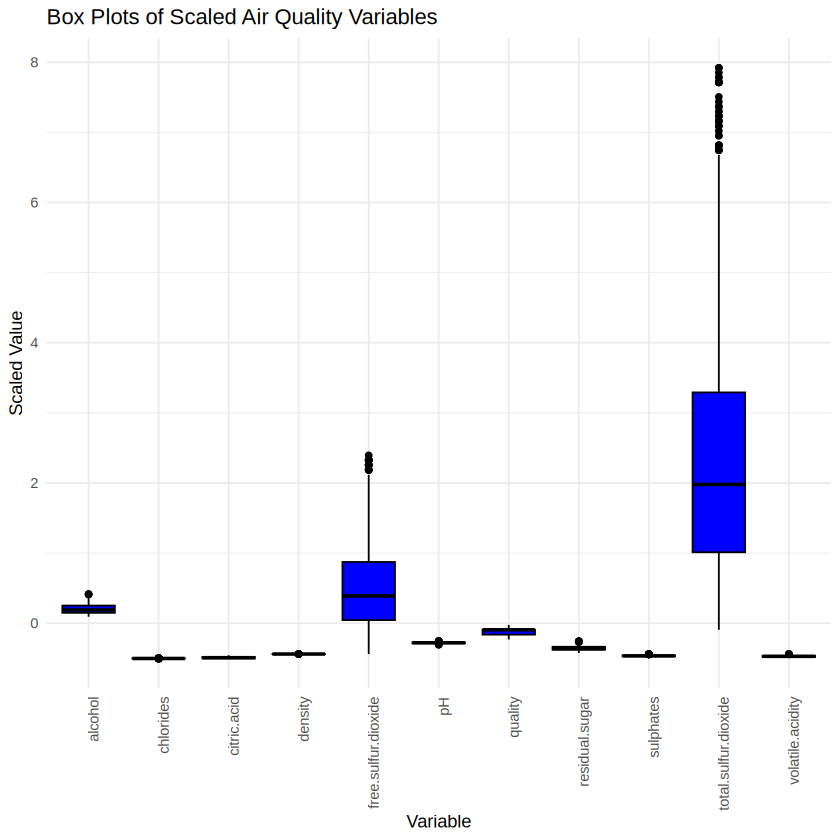

In [26]:
# 2. Box Plots of Scaled Data
ggplot(wine_quality_red_long, aes(x = variable, y = value)) +
  geom_boxplot(fill = "blue", color = "black") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Box Plots of Scaled Air Quality Variables",
       x = "Variable",
       y = "Scaled Value")

## Phân tích đơn biến

In [27]:
names(wine_quality_red)

[1] "volatile.acidity"     "citric.acid"          "residual.sugar"      
 [4] "chlorides"            "free.sulfur.dioxide"  "total.sulfur.dioxide"
 [7] "density"              "pH"                   "sulphates"           
[10] "alcohol"              "quality"

### Khảo sát biến `fixed.acidity`

[1] "Optimal lambda:  -2"


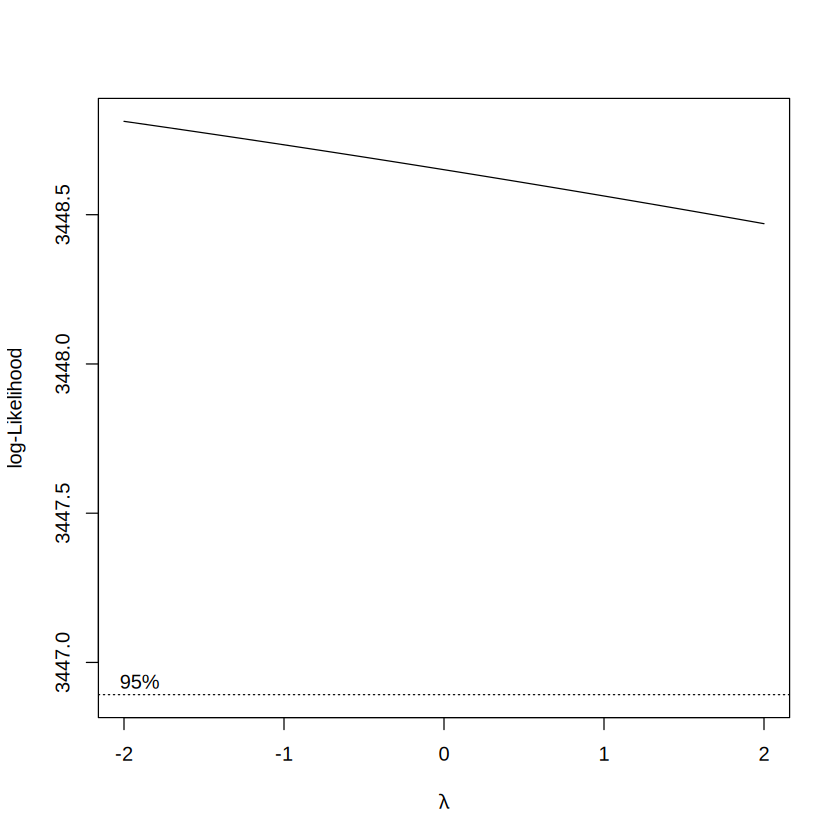

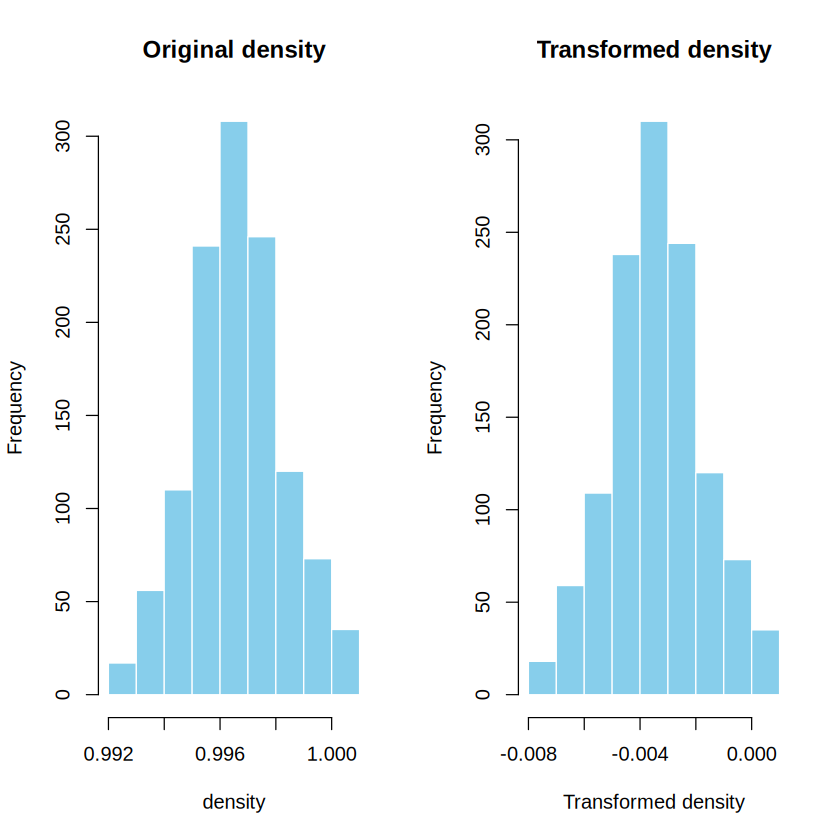

In [29]:
response_variable <- wine_quality_red$density

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original density", xlab = "density", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed density", xlab = "Transformed density", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `volatile.acidity`

[1] "Optimal lambda:  0.626262626262626"


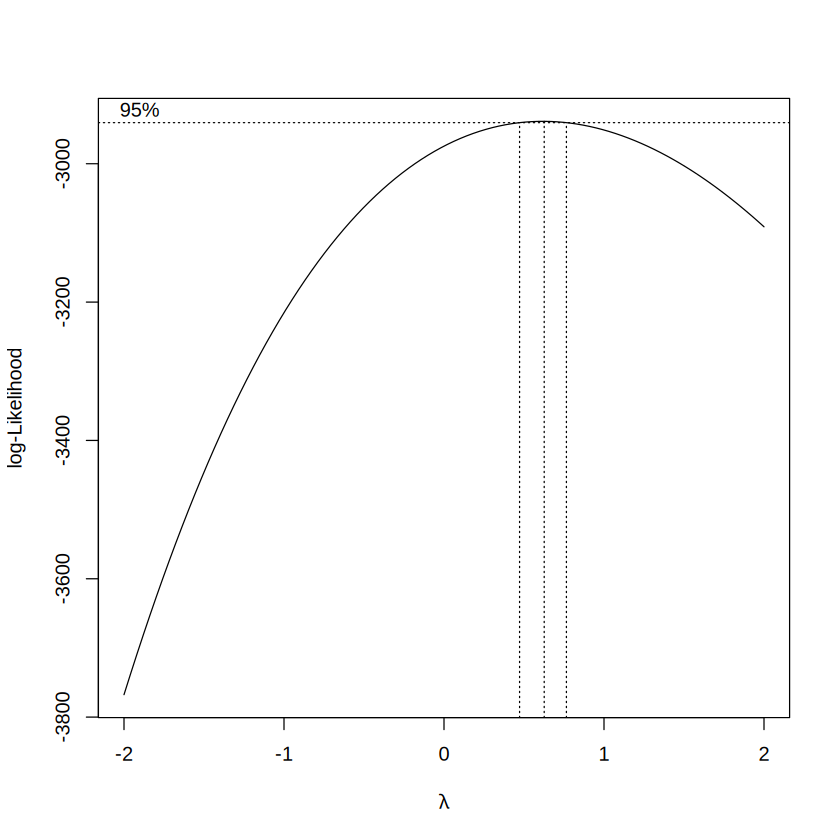

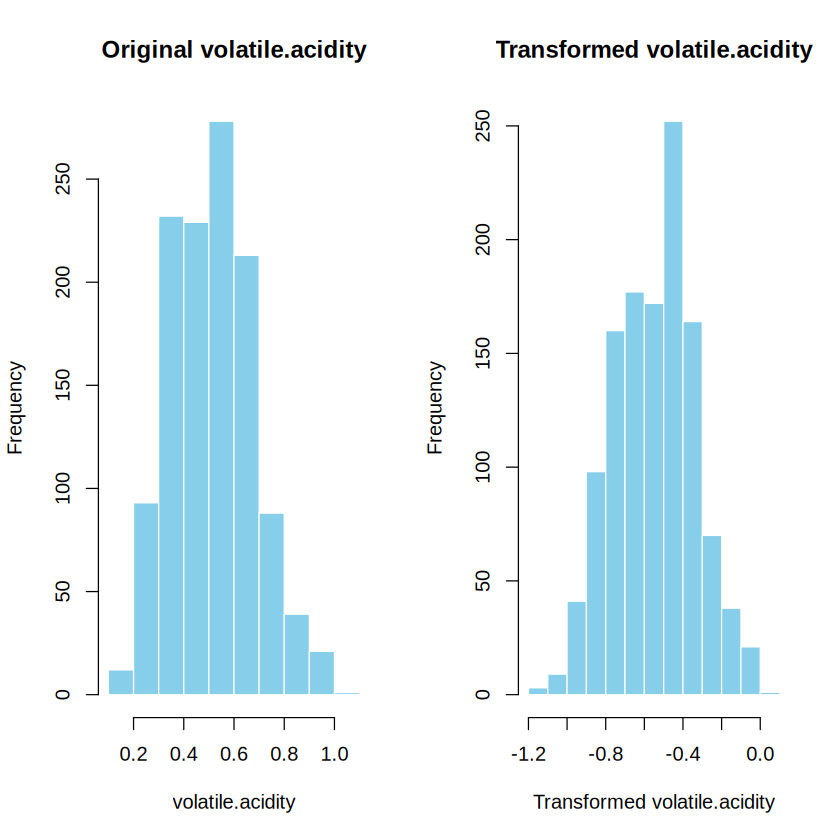

In [30]:
response_variable <- wine_quality_red$volatile.acidity

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original volatile.acidity", xlab = "volatile.acidity", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed volatile.acidity", xlab = "Transformed volatile.acidity", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `citric.acid`

[1] "Optimal lambda:  -0.424242424242424"


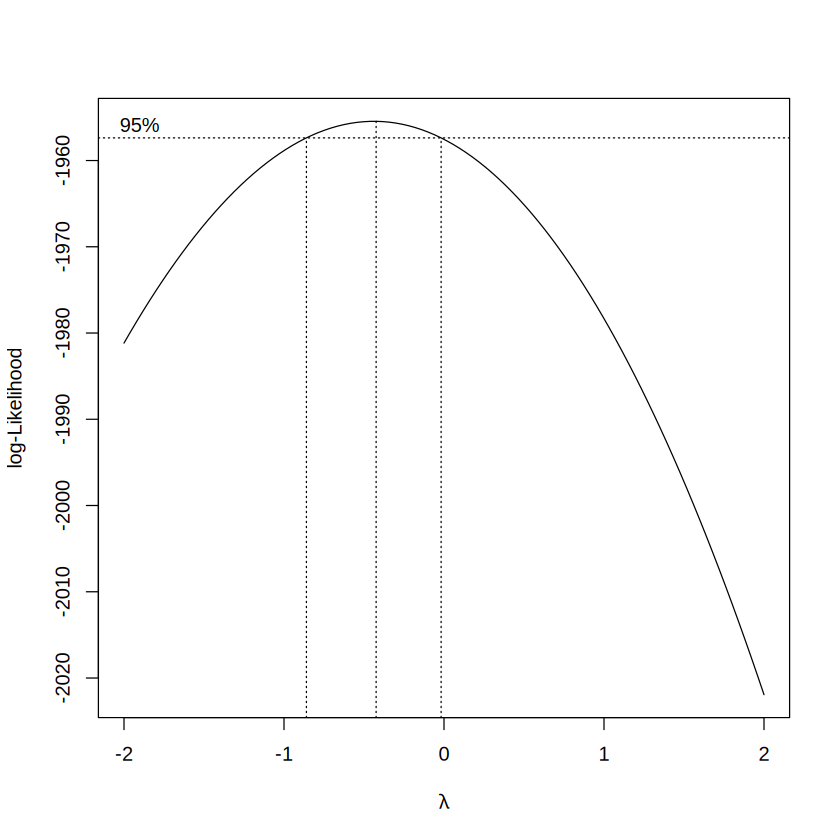

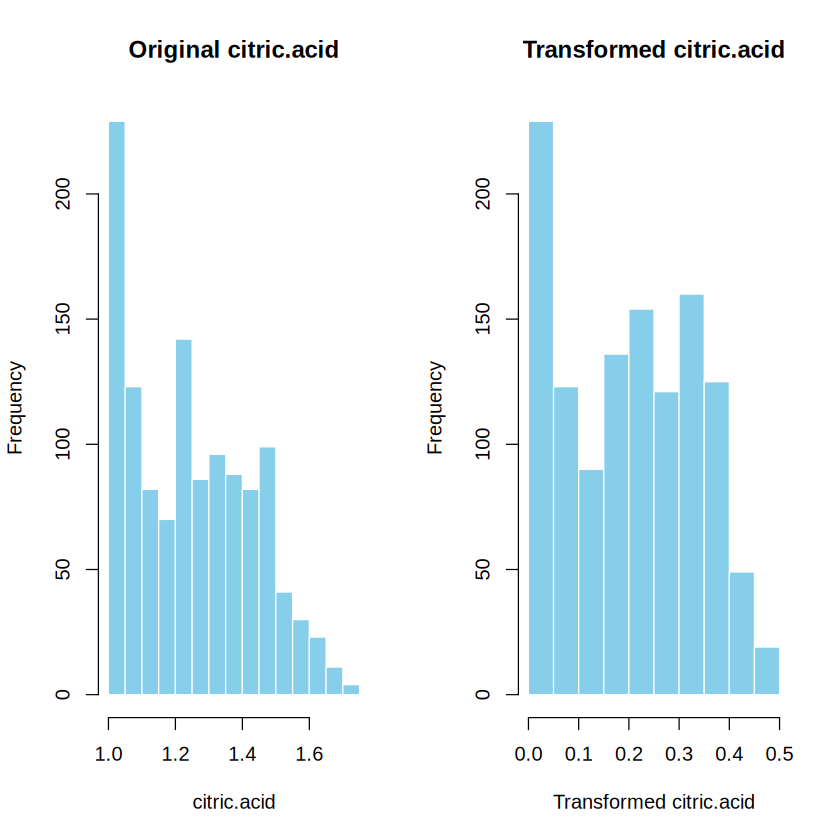

In [31]:
response_variable <- wine_quality_red$citric.acid

# Shift the values to be positive
shift_value <- abs(min(response_variable)) + 1
response_variable <- response_variable + shift_value

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original citric.acid", xlab = "citric.acid", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed citric.acid", xlab = "Transformed citric.acid", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `residual.sugar`

[1] "Optimal lambda:  -0.0202020202020201"


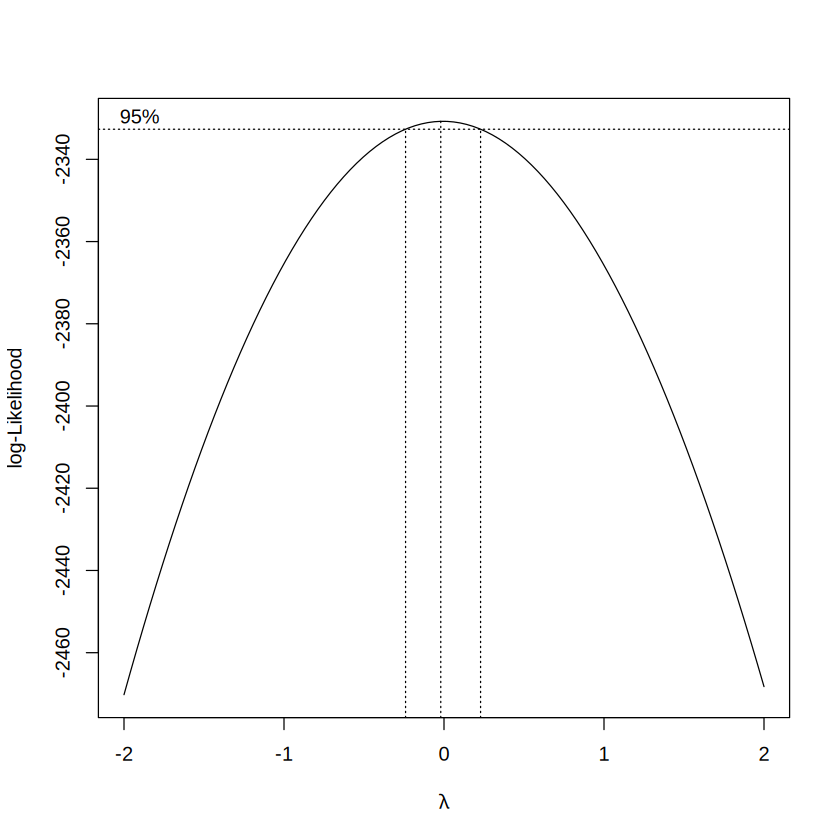

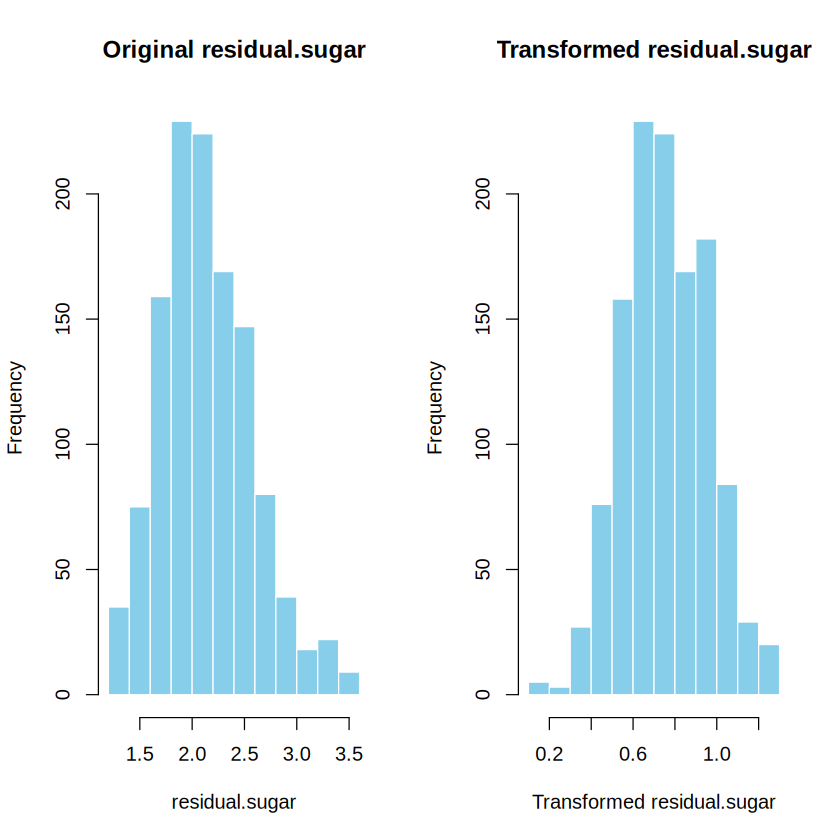

In [32]:
response_variable <- wine_quality_red$residual.sugar

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original residual.sugar", xlab = "residual.sugar", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed residual.sugar", xlab = "Transformed residual.sugar", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `chlorides`

[1] "Optimal lambda:  0.626262626262626"


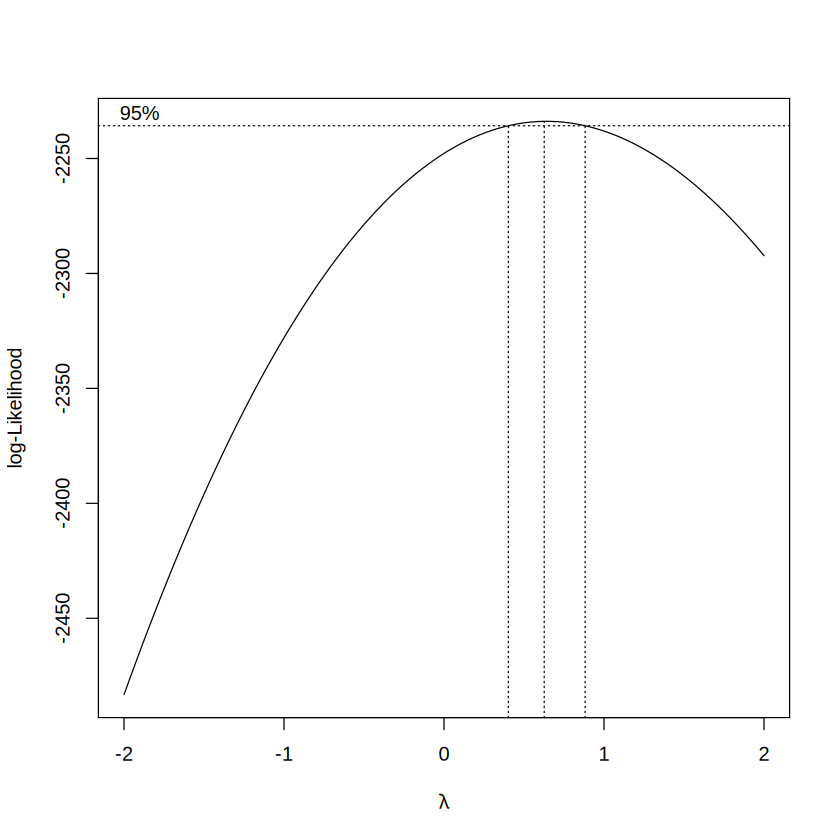

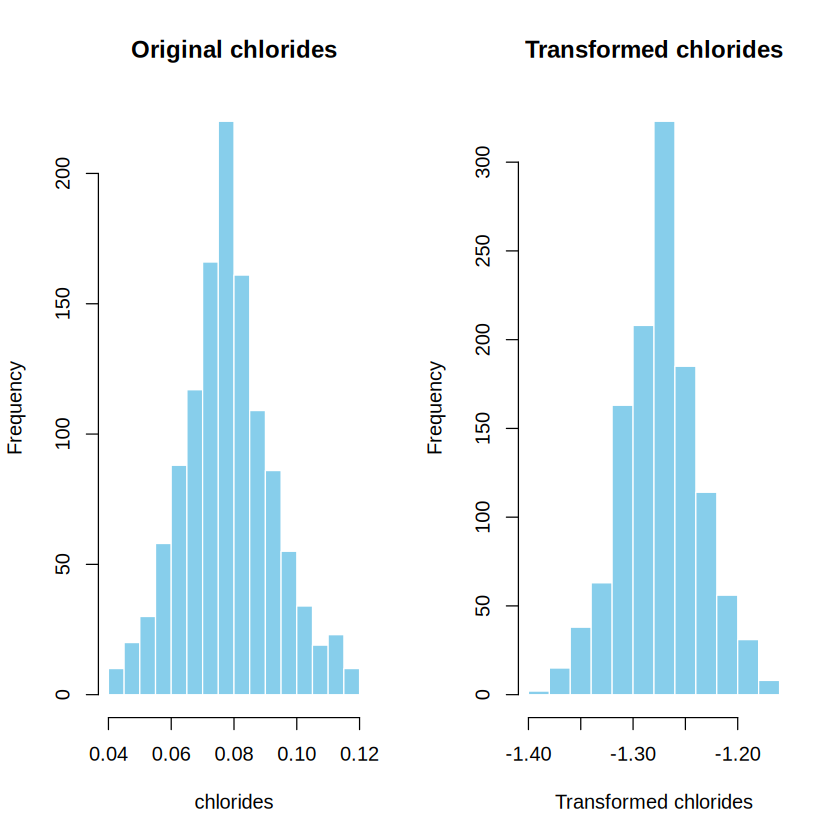

In [33]:
response_variable <- wine_quality_red$chlorides

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original chlorides", xlab = "chlorides", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed chlorides", xlab = "Transformed chlorides", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `free.sulfur.dioxide`

[1] "Optimal lambda:  0.222222222222222"


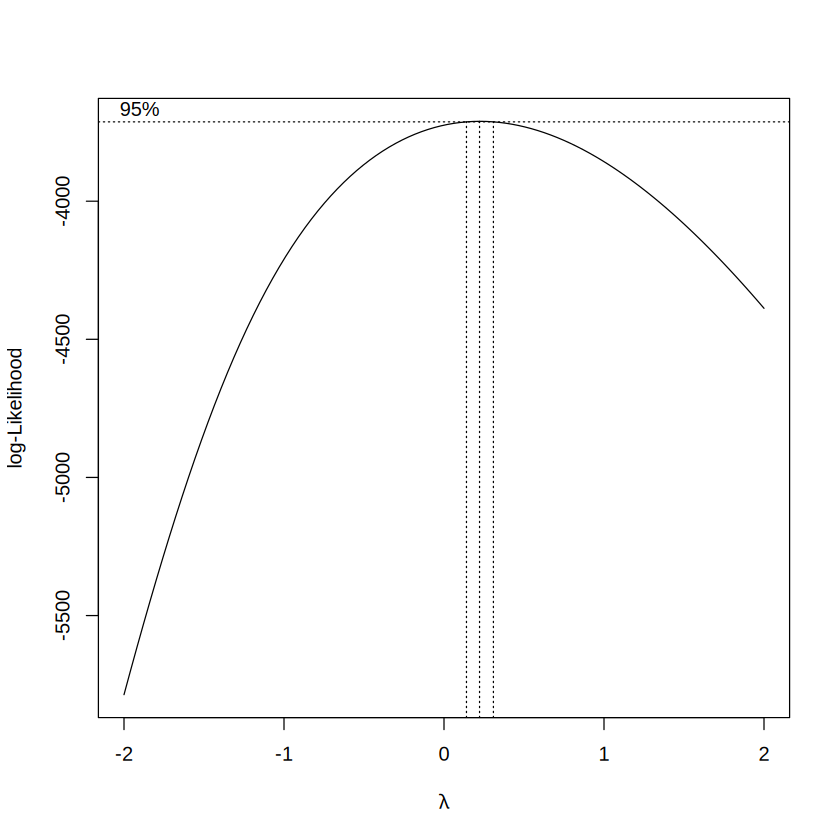

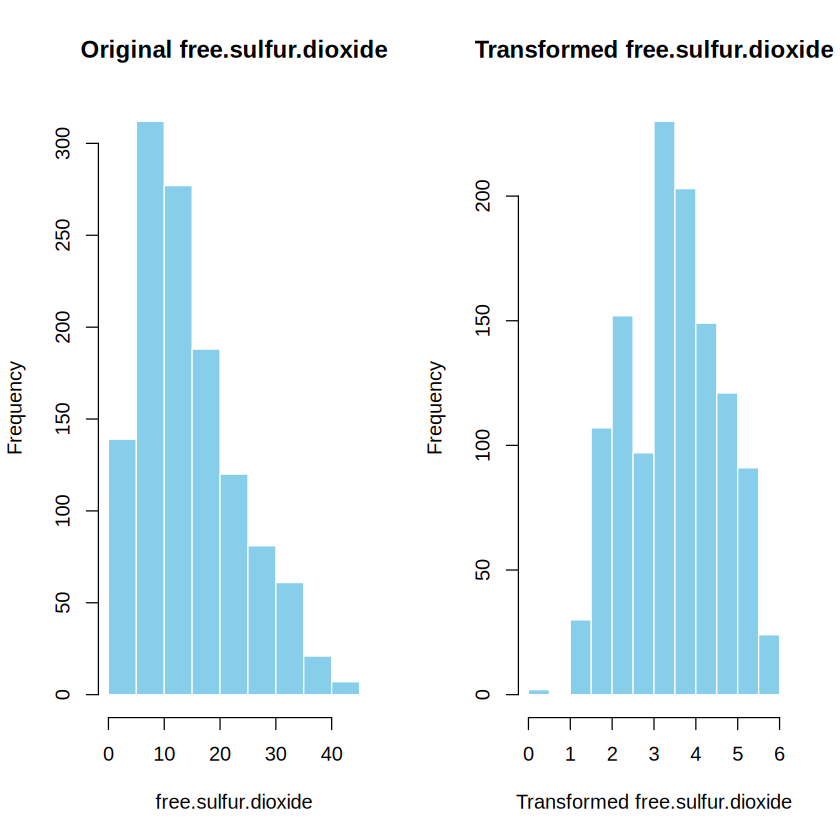

In [34]:
response_variable <- wine_quality_red$free.sulfur.dioxide

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original free.sulfur.dioxide", xlab = "free.sulfur.dioxide", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed free.sulfur.dioxide", xlab = "Transformed free.sulfur.dioxide", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `total.sulfur.dioxide`

[1] "Optimal lambda:  0.141414141414141"


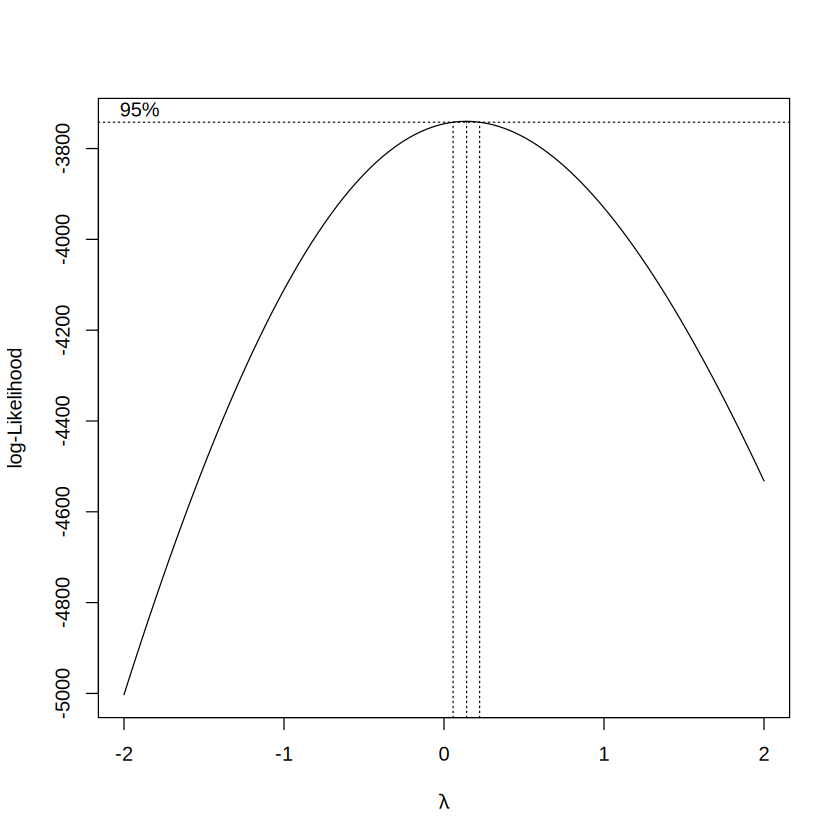

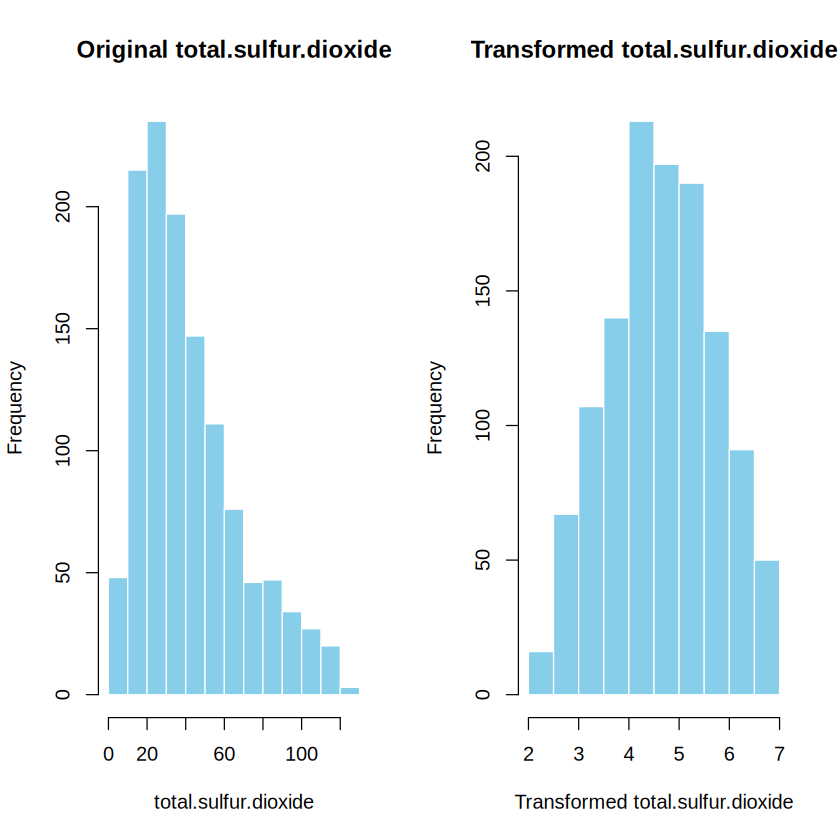

In [35]:
response_variable <- wine_quality_red$total.sulfur.dioxide

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original total.sulfur.dioxide", xlab = "total.sulfur.dioxide", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed total.sulfur.dioxide", xlab = "Transformed total.sulfur.dioxide", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `pH`

[1] "Optimal lambda:  0.666666666666667"


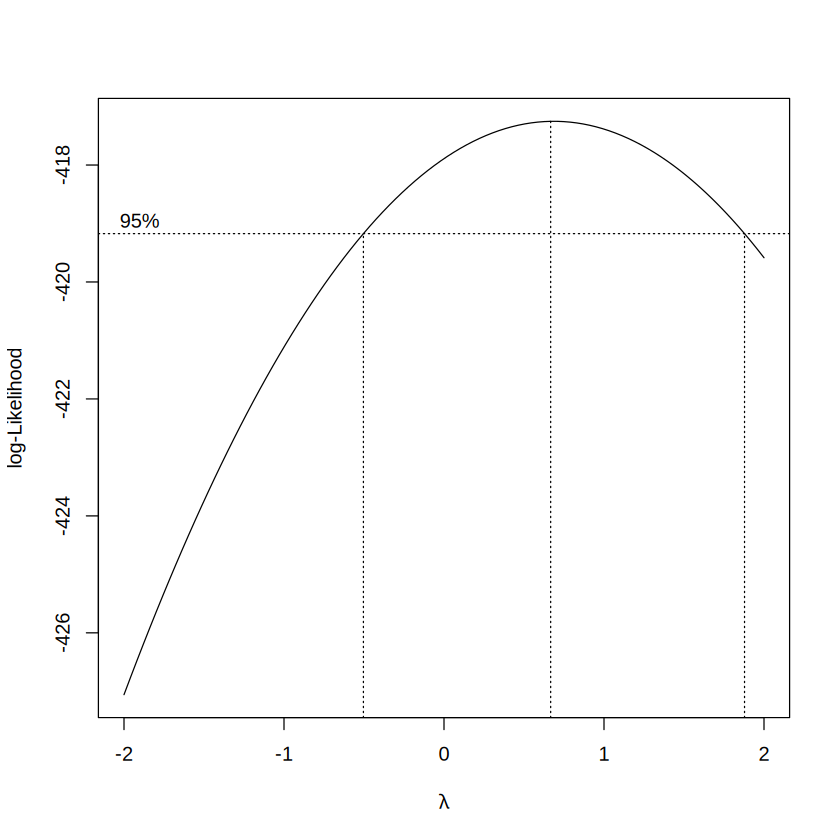

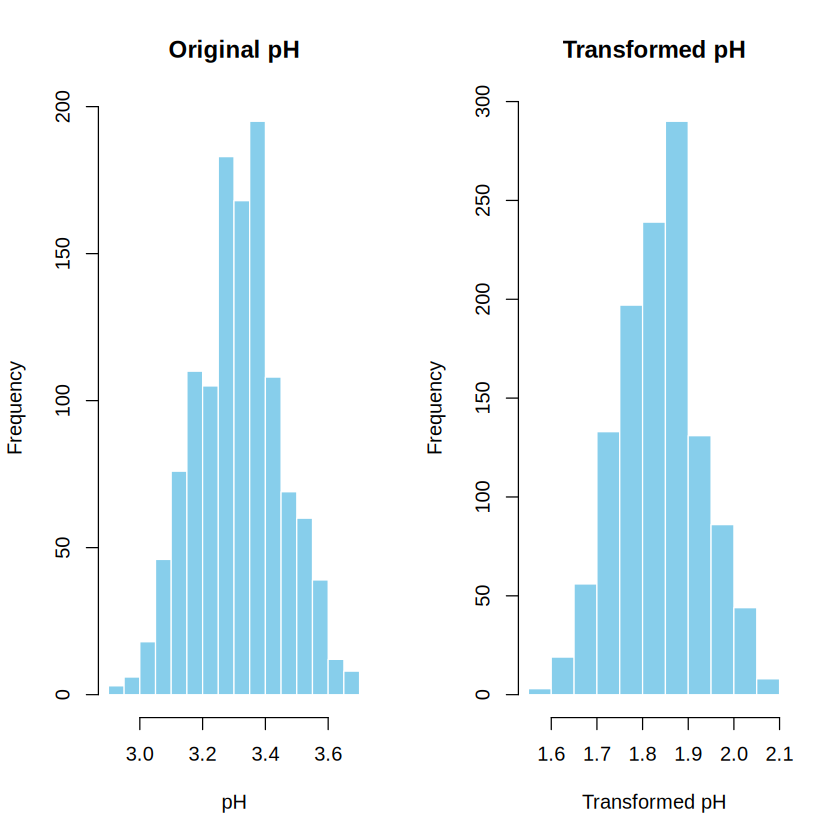

In [36]:
response_variable <- wine_quality_red$pH

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original pH", xlab = "pH", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed pH", xlab = "Transformed pH", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `sulphates`

[1] "Optimal lambda:  -0.343434343434343"


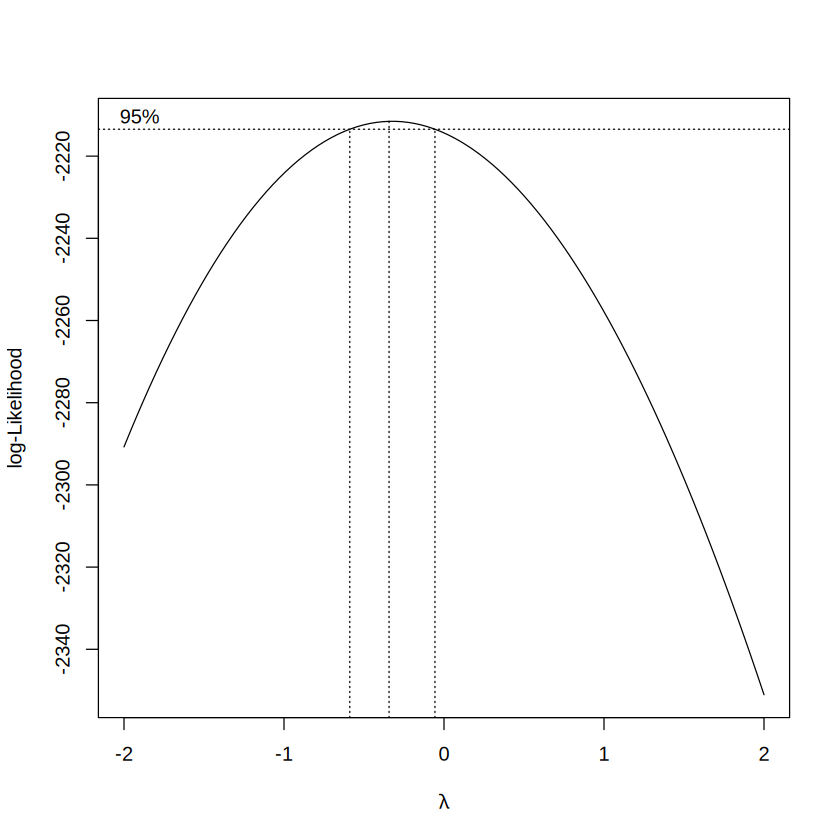

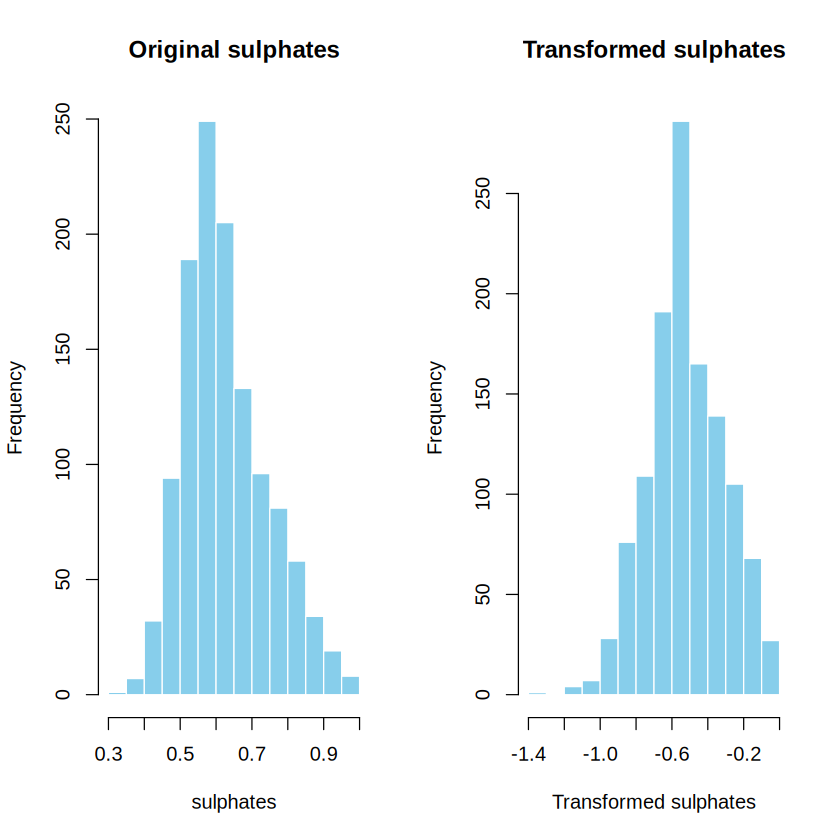

In [37]:
response_variable <- wine_quality_red$sulphates

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original sulphates", xlab = "sulphates", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed sulphates", xlab = "Transformed sulphates", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `alcohol` 

[1] "Optimal lambda:  -2"


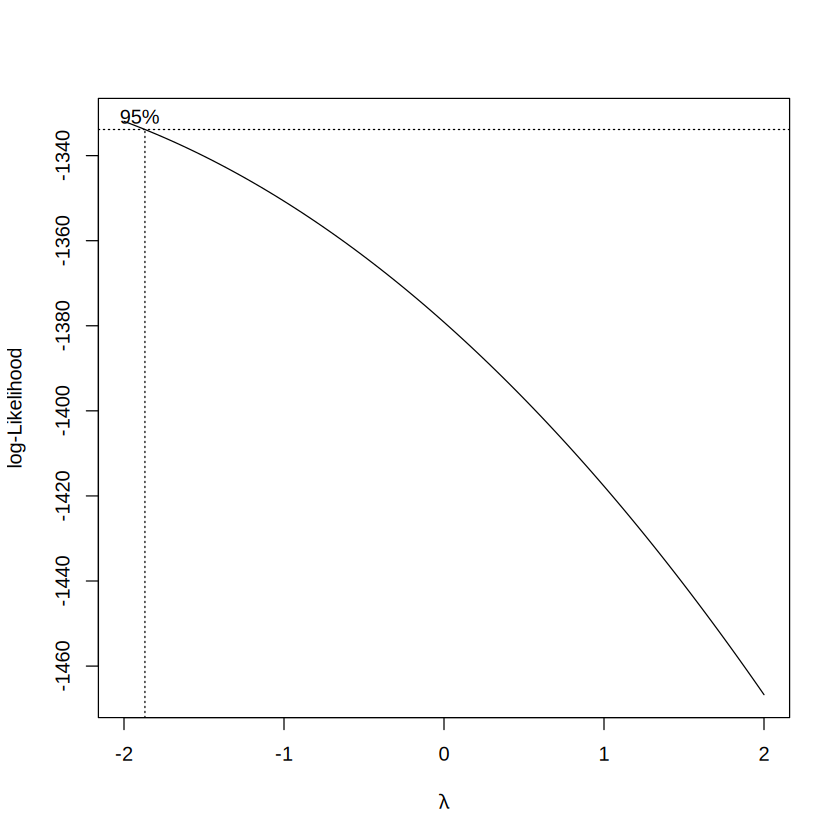

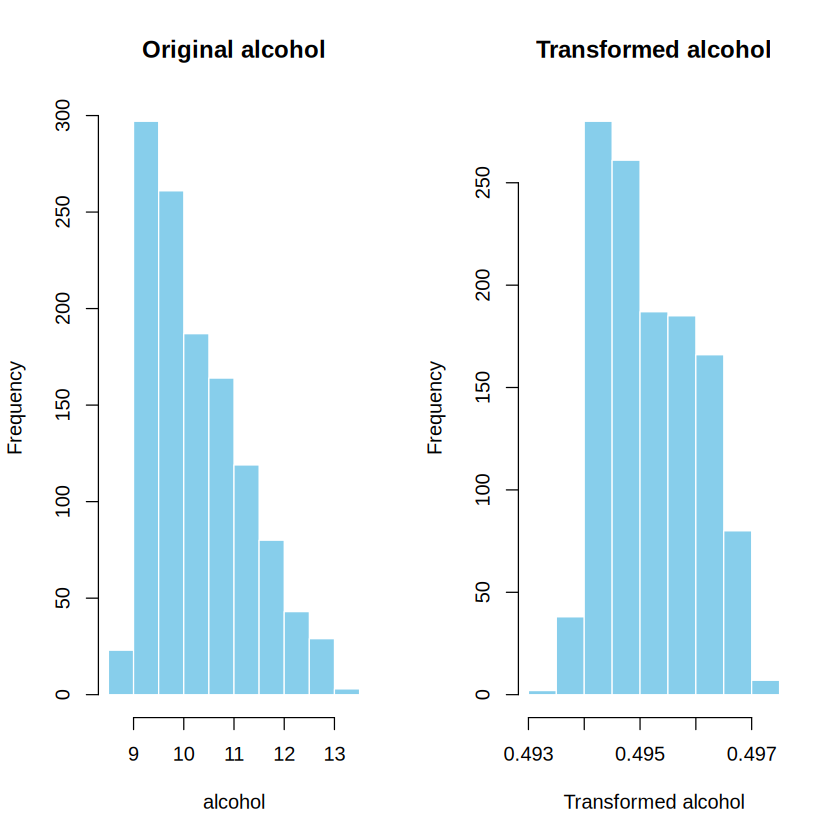

In [38]:
response_variable <- wine_quality_red$alcohol

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original alcohol", xlab = "alcohol", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed alcohol", xlab = "Transformed alcohol", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Biến đổi dữ liệu

In [39]:
wine_quality_red <- bc_transform(wine_quality_red)
head(wine_quality_red)

[1] "volatile.acidity"
[1] "Optimal lambda: -2"
[1] "citric.acid"
[1] "Optimal lambda: -2"
[1] "residual.sugar"
[1] "Optimal lambda: -2"
[1] "chlorides"
[1] "Optimal lambda: -2"
[1] "free.sulfur.dioxide"
[1] "Optimal lambda: -2"
[1] "total.sulfur.dioxide"
[1] "Optimal lambda: -2"
[1] "density"
[1] "Optimal lambda: -2"
[1] "pH"
[1] "Optimal lambda: -2"
[1] "sulphates"
[1] "Optimal lambda: -2"
[1] "alcohol"
[1] "Optimal lambda: -2"
[1] "quality"
[1] "Optimal lambda: -2"


,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.5204082,0.00000000,0.3614958,-86.06510,0.4958678,0.4995675,-0.002207281,0.4594159,-1.0943878,0.4943413,0.4800000
2,-0.1456612,0.00000000,0.4260355,-51.56164,0.4992000,0.4998886,-0.003215426,0.4511719,-0.5813149,0.4947938,0.4800000
3,-0.3656510,0.03772189,0.4054820,-58.57372,0.4977778,0.4998285,-0.003013554,0.4529527,-0.6834320,0.4947938,0.4800000
4,-5.8775510,0.29454306,0.3614958,-88.38889,0.4982699,0.4998611,-0.002006016,0.4499279,-0.9863258,0.4947938,0.4861111
5,-0.5204082,0.00000000,0.3614958,-86.06510,0.4958678,0.4995675,-0.002207281,0.4594159,-1.0943878,0.4943413,0.4800000
6,-0.6478421,0.00000000,0.3456790,-88.38889,0.4970414,0.4996875,-0.002207281,0.4594159,-1.0943878,0.4943413,0.4800000


## Phân tích đa biến

## Phân chia tập dữ liệu

In [40]:
split_ratio <- 0.8
split_index <- floor(nrow(wine_quality_red) * split_ratio)

train = wine_quality_red[1:split_index,]
test = wine_quality_red[(split_index + 1):nrow(wine_quality_red),]

In [41]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 964  11

In [42]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 242  11

In [43]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	964 obs. of  11 variables:
 $ volatile.acidity    : num  -0.52 -0.146 -0.366 -5.878 -0.52 ...
 $ citric.acid         : num  0 0 0.0377 0.2945 0 ...
 $ residual.sugar      : num  0.361 0.426 0.405 0.361 0.361 ...
 $ chlorides           : num  -86.1 -51.6 -58.6 -88.4 -86.1 ...
 $ free.sulfur.dioxide : num  0.496 0.499 0.498 0.498 0.496 ...
 $ total.sulfur.dioxide: num  0.5 0.5 0.5 0.5 0.5 ...
 $ density             : num  -0.00221 -0.00322 -0.00301 -0.00201 -0.00221 ...
 $ pH                  : num  0.459 0.451 0.453 0.45 0.459 ...
 $ sulphates           : num  -1.094 -0.581 -0.683 -0.986 -1.094 ...
 $ alcohol             : num  0.494 0.495 0.495 0.495 0.494 ...
 $ quality             : num  0.48 0.48 0.48 0.486 0.48 ...


## Mô hình hóa hồi quy tuyến tính đa biến

### Xây dựng mô hình đầy đủ

In [44]:
full.lm <- lm(quality ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = quality ~ ., data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0157641 -0.0020458  0.0000231  0.0026734  0.0085998 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -2.628e-01  1.117e-01  -2.352  0.01888 *  
volatile.acidity     -1.964e-04  4.958e-05  -3.962 7.99e-05 ***
citric.acid          -2.900e-04  1.716e-03  -0.169  0.86587    
residual.sugar       -1.490e-03  2.889e-03  -0.516  0.60613    
chlorides            -3.371e-06  3.666e-06  -0.920  0.35793    
free.sulfur.dioxide   1.964e-03  5.061e-03   0.388  0.69807    
total.sulfur.dioxide  1.344e-02  8.304e-02   0.162  0.87144    
density              -1.657e-01  1.077e-01  -1.538  0.12429    
pH                   -1.175e-01  3.680e-02  -3.193  0.00145 ** 
sulphates             2.603e-03  2.688e-04   9.686  < 2e-16 ***
alcohol               1.603e+00  1.978e-01   8.104 1.63e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*

### Lựa chọn mô hình tốt nhất

In [45]:
# Mô hình chặn dưới
model.lb <- lm(quality ~ 1, data = train)

In [46]:
# Mô hình chặn trên
model.up <- full.lm

In [47]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = quality ~ volatile.acidity + density + pH + sulphates + 
    alcohol, data = train)

Coefficients:
     (Intercept)  volatile.acidity           density                pH  
      -0.2409339        -0.0001953        -0.2226463        -0.1148458  
       sulphates           alcohol  
       0.0026233         1.5706105  


In [49]:
wqr_models <- regsubsets(quality ~ volatile.acidity + density + pH + sulphates + alcohol, data = train)
summary.wqr <-summary(wqr_models)

In [50]:
# Lựa chọn mô hình tốt nhất từ reg subsets
summary.wqr$which

,(Intercept),volatile.acidity,density,pH,sulphates,alcohol
1,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE
2,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE
3,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE
4,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


Tiêu chí chọn mô hình tốt nhất 1: mô hình với $R^2$ lớn (tương ứng với MSE nhỏ)

In [51]:
summary.wqr$rsq

[1] 0.1941715 0.2785536 0.2966909 0.3032590 0.3080438

Tiêu chí chọn mô hình tốt nhất 2: mô hình với $R^2$ hiệu chỉnh lớn

In [52]:
# model with largest adjusted R^2
summary.wqr$adjr2

[1] 0.1933339 0.2770521 0.2944931 0.3003529 0.3044324

Tiêu chí chọn mô hình tốt nhất 3: mô hình với Mallow's Cp nhỏ

In [53]:
# model with smallest Mallow's Cp
summary.wqr$cp

[1] 155.65398  40.82867  17.71791  10.62447   6.00000

#### Chọn mô hình tốt nhất dựa trên BIC

In [54]:
# Tiêu chí chọn mô hình tốt nhất 4: mô hình với BIC nhỏ
summary.wqr$bic

[1] -194.3704 -294.1300 -311.8039 -313.9778 -313.7497

In [55]:
best_model_index <- which.min(summary.wqr$bic)
best_model <- summary.wqr$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

     (Intercept) volatile.acidity          density               pH 
            TRUE             TRUE            FALSE             TRUE 
       sulphates          alcohol 
            TRUE             TRUE 
[1] "volatile.acidity" "pH"               "sulphates"        "alcohol"         


In [56]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("quality ~", paste(best_vars, collapse = " + "))
best_model_wqr <- lm(as.formula(formula_str), data=train)

In [57]:
# Tóm tắt mô hình
summary(best_model_wqr)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0159958 -0.0019870  0.0000462  0.0026282  0.0093295 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -3.648e-01  7.233e-02  -5.043 5.48e-07 ***
volatile.acidity -2.034e-04  4.444e-05  -4.577 5.33e-06 ***
pH               -9.308e-02  3.096e-02  -3.007  0.00271 ** 
sulphates         2.434e-03  2.522e-04   9.648  < 2e-16 ***
alcohol           1.802e+00  1.464e-01  12.310  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003626 on 959 degrees of freedom
Multiple R-squared:  0.3033,	Adjusted R-squared:  0.3004 
F-statistic: 104.4 on 4 and 959 DF,  p-value: < 2.2e-16


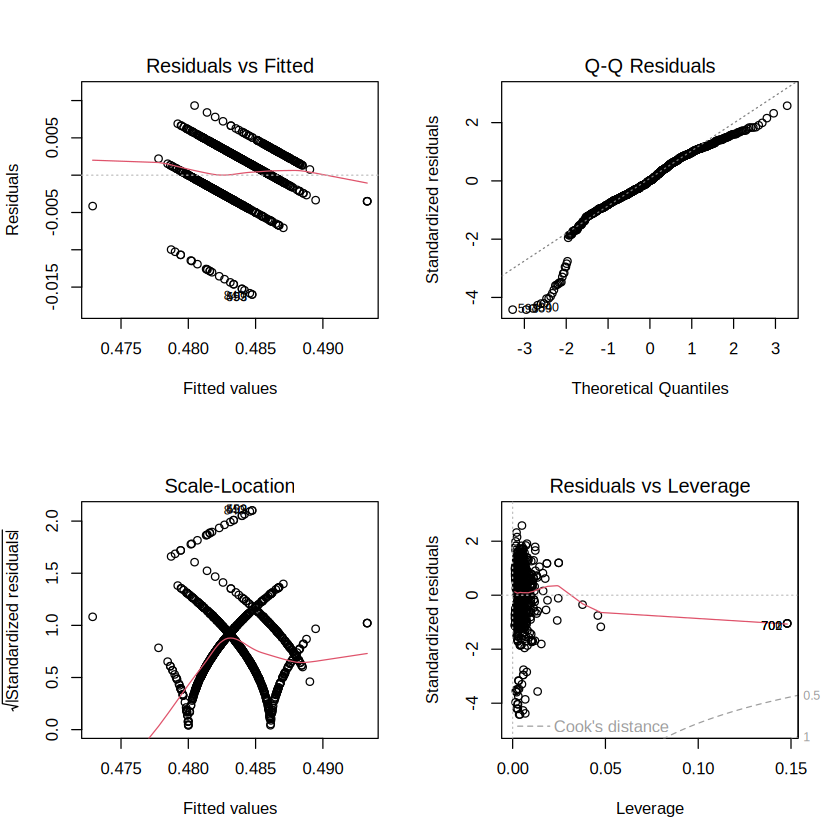

In [58]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_wqr)

#### Phân tích Residuals vs Fitted Plot

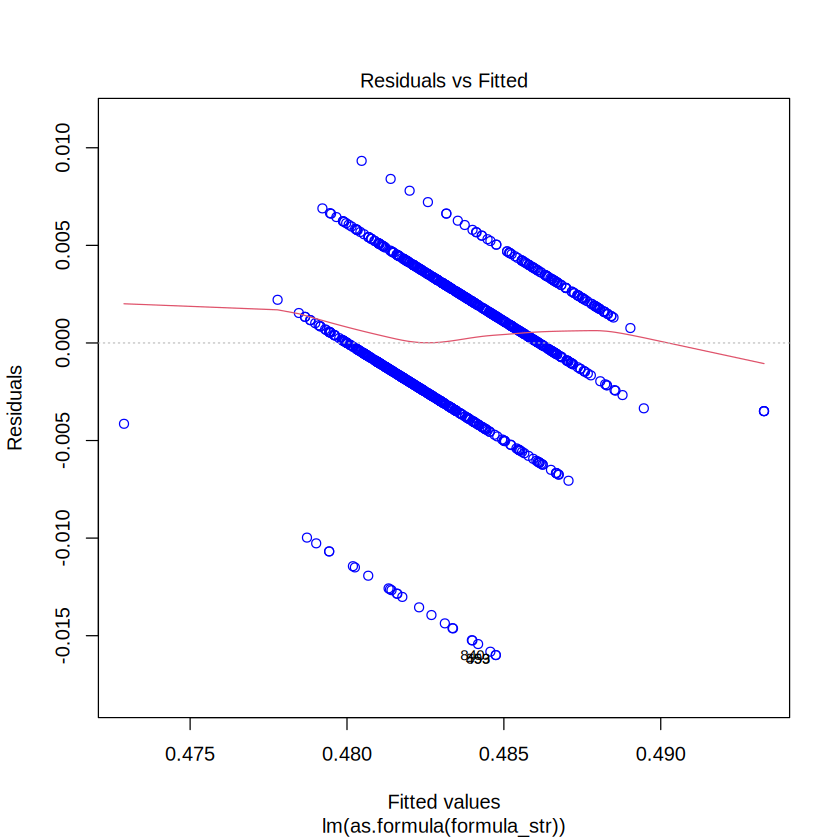

In [59]:
plot(best_model_wqr, which=1, col=c("blue")) # Residuals vs Fitted Plot

#### Phân tích Normal Q–Q (quantile-quantile) Plot


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.93328, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


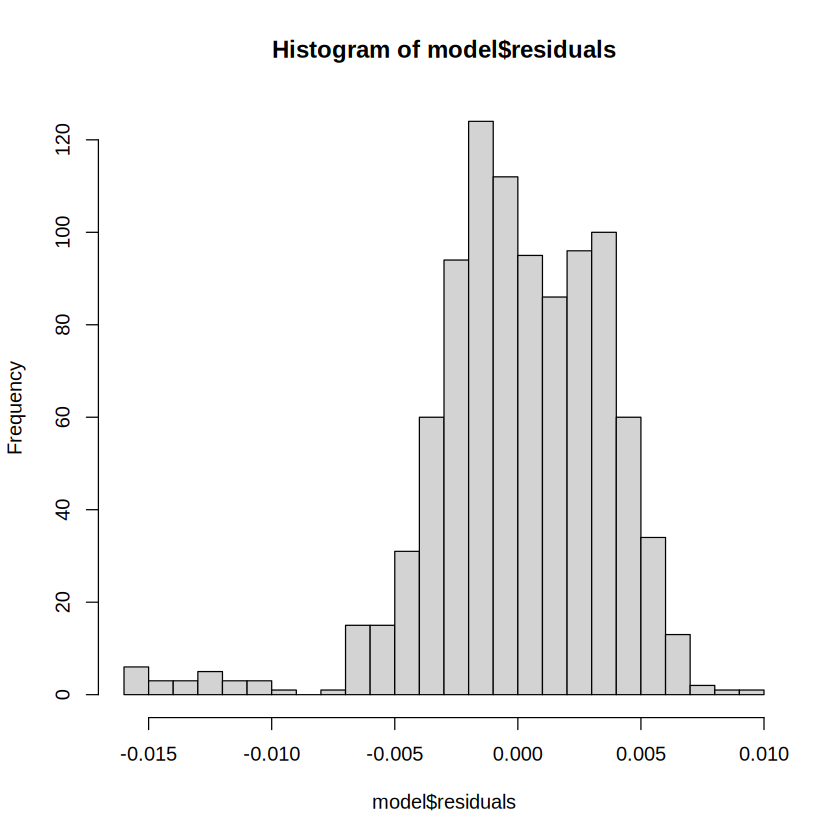

In [60]:
CheckNormal(model = best_model_wqr)

#### Phân tích Scale-Location


	studentized Breusch-Pagan test

data:  model
BP = 8.4069, df = 4, p-value = 0.07776

[1] "H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)"


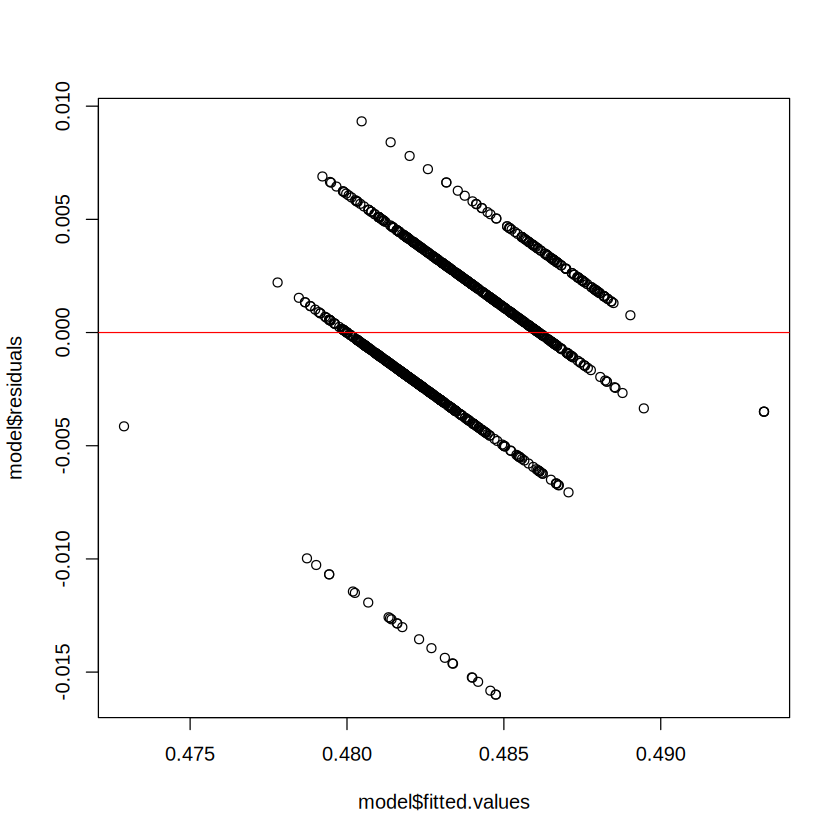

In [61]:
CheckHomos(best_model_wqr)

In [62]:
# Xây dựng ngưỡng cho Cook Distance
threshold <- 4 / nrow(train)
threshold

[1] 0.004149378


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.007480 -0.002095 -0.000262  0.002299  0.008038 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -4.160e-01  5.942e-02  -7.002 4.90e-12 ***
volatile.acidity -3.010e-04  5.239e-05  -5.745 1.25e-08 ***
pH               -4.779e-02  2.548e-02  -1.875   0.0611 .  
sulphates         2.089e-03  2.161e-04   9.668  < 2e-16 ***
alcohol           1.864e+00  1.198e-01  15.554  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.002839 on 910 degrees of freedom
Multiple R-squared:  0.3941,	Adjusted R-squared:  0.3914 
F-statistic:   148 on 4 and 910 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.98735, p-value = 4.247e-07

[1] "H0 rejected: the residuals are NOT distributed normally"


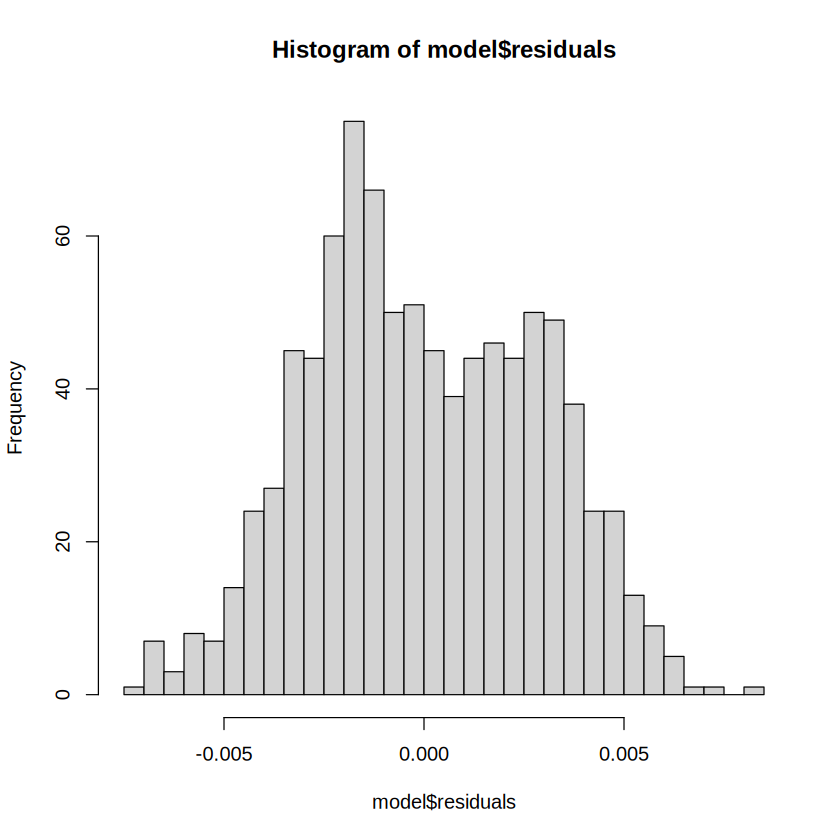


	studentized Breusch-Pagan test

data:  model
BP = 19.059, df = 4, p-value = 0.0007652

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


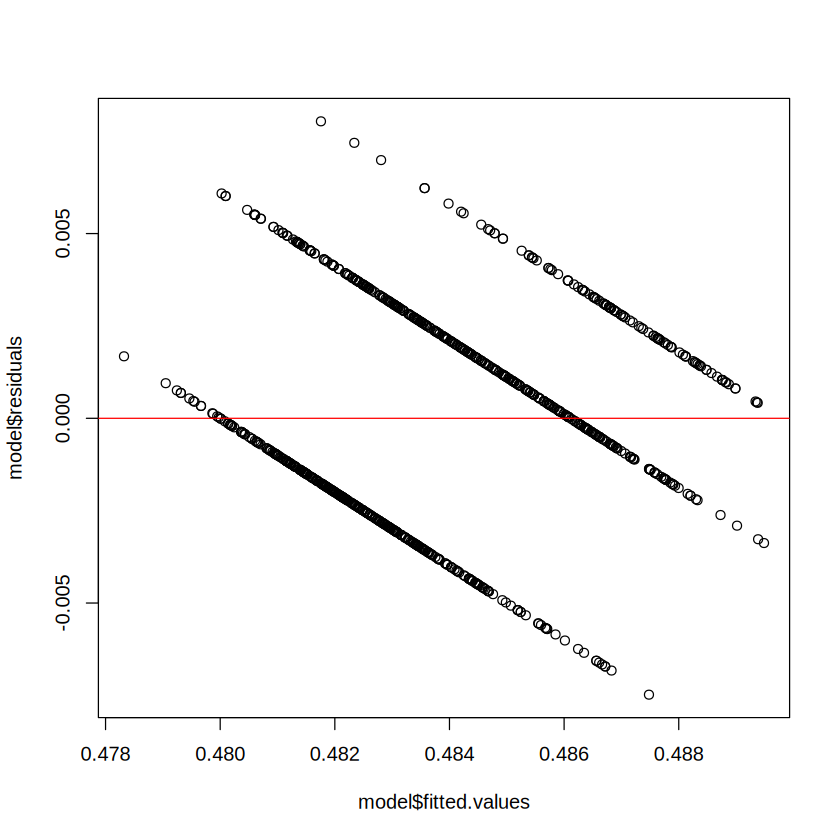

In [63]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.2 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.2)

# Shapiro-Wilk normality test
# shapiro.test(residuals(best_model_wqr.2))
CheckNormal(best_model_wqr.2)

# Breusch-Pagan Test
# bptest(best_model_wqr.2)
CheckHomos(best_model_wqr.2)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0161155 -0.0020125  0.0000567  0.0025761  0.0093630 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -3.833e-01  7.158e-02  -5.355 1.08e-07 ***
volatile.acidity -1.800e-04  4.391e-05  -4.099 4.51e-05 ***
pH               -9.053e-02  3.101e-02  -2.920  0.00359 ** 
sulphates         2.534e-03  2.509e-04  10.096  < 2e-16 ***
alcohol           1.837e+00  1.449e-01  12.682  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003535 on 922 degrees of freedom
Multiple R-squared:  0.3191,	Adjusted R-squared:  0.3161 
F-statistic:   108 on 4 and 922 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.94316, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


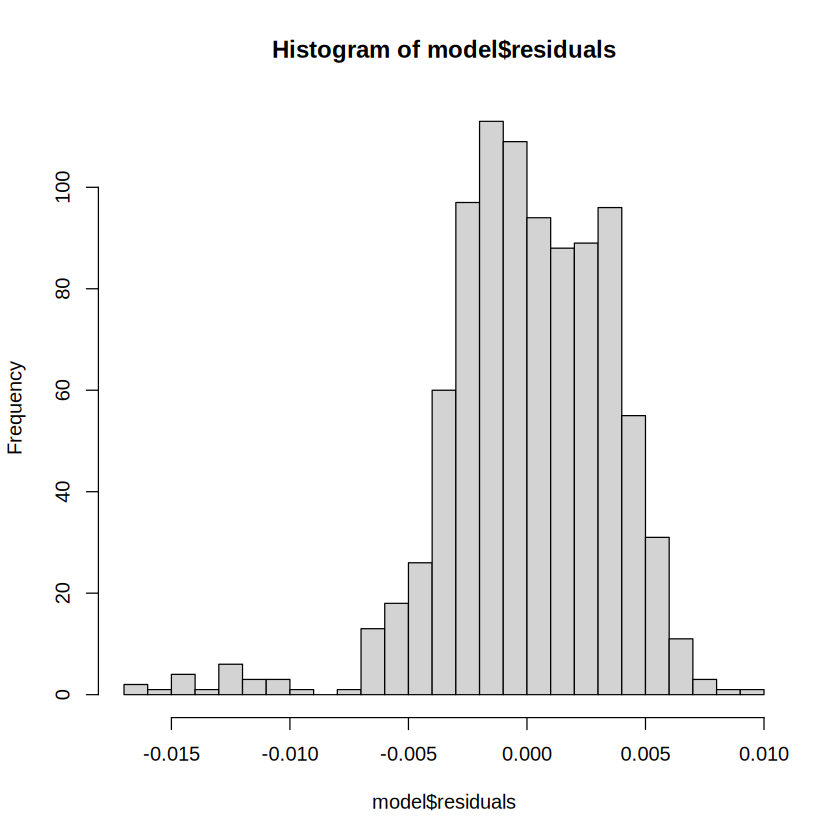


	studentized Breusch-Pagan test

data:  model
BP = 9.0424, df = 4, p-value = 0.06005

[1] "H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)"


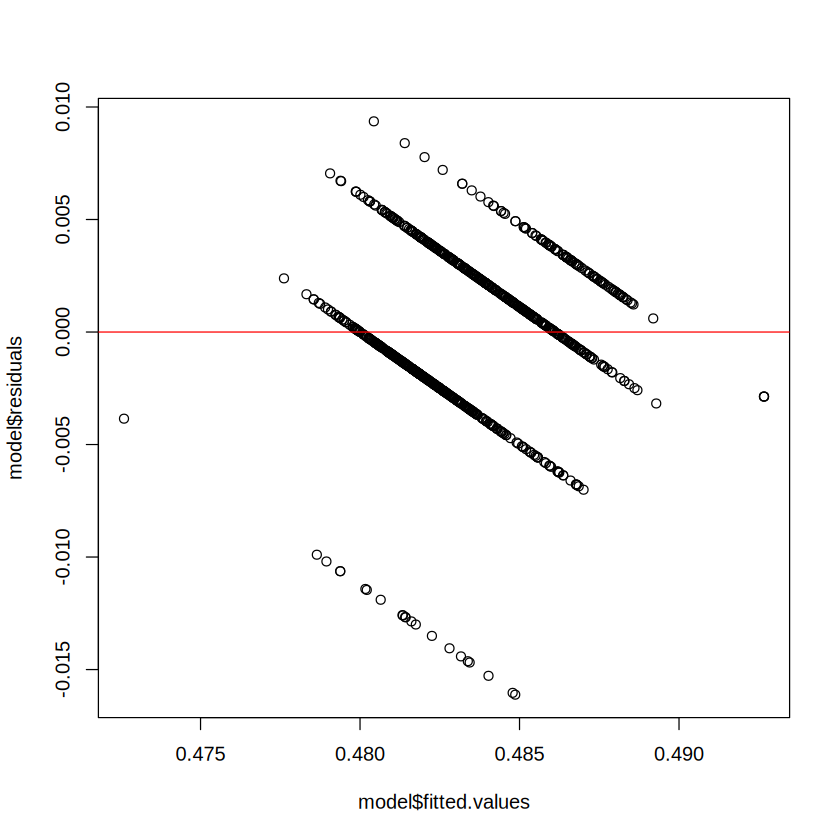

In [64]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr.2)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.3 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.3)

# Shapiro-Wilk normality test
CheckNormal(best_model_wqr.3)

# Breusch-Pagan Test
CheckHomos(best_model_wqr.3)

## Đánh giá hiệu suất và dự đoán kết quả

[1] "MSE: 1.5e-05"
[1] "RMSE: 0.00382"
[1] "MAE: 0.002825"
[1] "Correlation: 0.509805"
[1] "R^2 between y_pred & y_true: 0.259901"


[1] 0.003819632

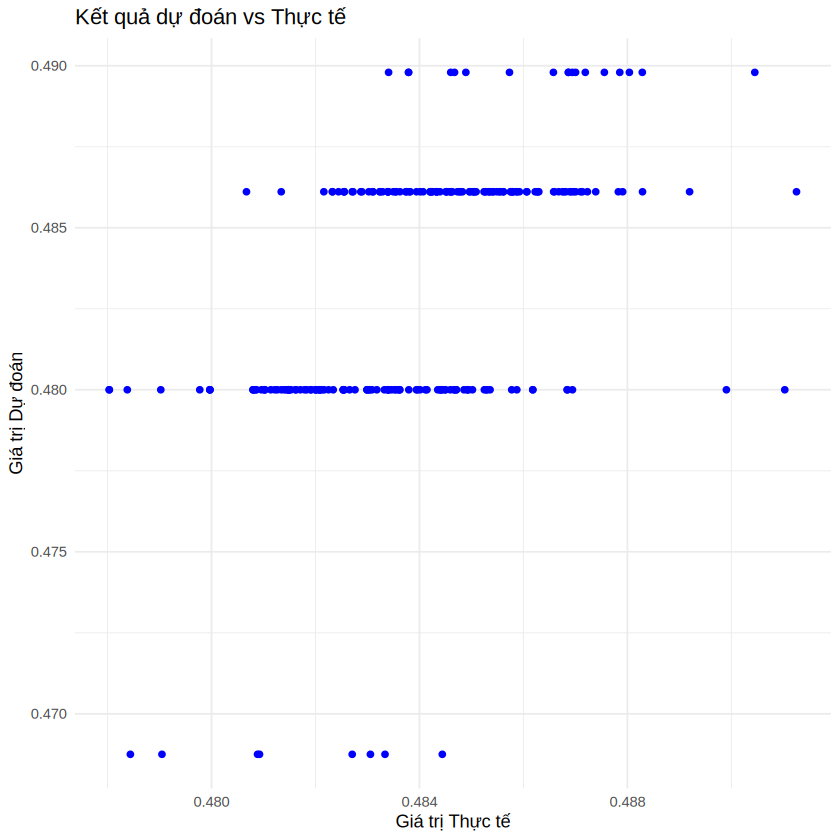

In [65]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_wqr.2, test)
df <- data.frame(
    du_doan <- results,
    label <- test$quality
)

metrics(results, test$quality)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$quality)